In [1]:
from splitters import k_fold_edge_split, train_test_split_edges
from dataset_loader import load_dataframes
from model import Net
from utils import train_model, device_finder, train_model_on_folds, predict_edges, plot_layers_curve, plotter, create_drugs_info_list_and_dict
from utils import train_model_on_folds_and_decode_all, predict_new_edges, predict_top_edges, all_features_graph_data, save_preds_in_csv
from utils import predict_all_top_edges, predict_top_new_edges
import warnings
from graph_data_creater import create_graph_data_with_different_features, create_graph_data
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch_geometric.transforms import LocalDegreeProfile
import torch
from torch_geometric.data import Data
import numpy as np
# plotting shapes
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# ignoring warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

df_list = [final_dt_df, final_w2v_df, final_nv_df, final_fin_df, final_in_df, final_se_df, all_df] = load_dataframes()
data_list, reverse_node_dict_list = create_graph_data_with_different_features(with_reverse=True)
[data_dt, data_w2v, data_n2v, data_fin, data_in, data_se] = data_list
[nodes_dt_dict, nodes_w2v_dict, nodes_n2v_dict, nodes_fin_dict, nodes_in_dict, nodes_se_dict] = reverse_node_dict_list

In [ ]:
device = device_finder()
# number of channels
hid_channels = 128
out_channels = 64

all_t_list = []
all_v_list = []
all_te_list = []
all_prob_adj_list = []

for data in data_list:
# for data in [data_n2v, data_dt]:
    # creating folds
    folds = k_fold_edge_split(data, only_upper_triangular_portion=False)
    in_channels = folds[0].num_features

    t_list = []
    v_list = []
    te_list = []
    prob_adj_list = []

    for index in range(0, 6):
    # for index in range(0, 3):
        train_loss, val_auc, test_auc, model, prob_adj = train_model_on_folds_and_decode_all(folds=folds, data=data,
                                    num_epochs=101, index=index, in_channels=in_channels, hid_channels=hid_channels, 
                                    out_channels=out_channels, device=device, model_class=Net, lr=0.0005, verbose=0)    
        t_list.append(train_loss[99])
        v_list.append(val_auc[99])
        te_list.append(test_auc[99])
        prob_adj_list.append(prob_adj)
    
    all_t_list.append(t_list)
    all_v_list.append(v_list)
    all_te_list.append(te_list)
    all_prob_adj_list.append(prob_adj_list)

In [5]:
all_top_pairs = predict_all_top_edges(all_prob_adj_list, data_list)
all_new_pairs = predict_top_new_edges(all_top_pairs)

In [13]:
print(len(all_new_pairs))
print(len(all_new_pairs[0]))

36
85


In [26]:
import pathlib
import os

def save_preds_in_csv(all_new_pairs, reverse_node_dict, name):
    d1_names = []
    d2_names = []
    for edge in all_new_pairs:
        a1 = reverse_node_dict[edge[0]]
        a2 = reverse_node_dict[edge[1]]
        d1_names.append(a1)
        d2_names.append(a2)
    all_new_pairs = np.array(all_new_pairs)
    temp_df = pd.DataFrame()
    try:
        temp_df['a1'] = all_new_pairs[:, 0]
        temp_df['a2'] = all_new_pairs[:, 1]
        temp_df['d1'] = d1_names
        temp_df['d2'] = d2_names
    except Exception as e:
        print(name)

    out_dir = str(pathlib.Path().resolve())
    out_path = f'{out_dir}/predictions/{name}.csv'

    if 'predictions' not in os.listdir(out_dir):
        os.mkdir(f'{out_dir}/predictions/')

    temp_df.to_csv(out_path, index=False)

In [27]:
data_list_names = ['drug_target', 'word2vec', 'node2vec', 'drug_finger', 'indication', 'side_effec']
model_list_names = ['GCN', 'SAGE', 'GAT', 'SAGE-GCN', 'GAT-SAGE', 'GCN-GAT']

m_names = []

for i in data_list_names:
    for j in model_list_names:
        m_names.append(f'{j}-{i}')

for i, new_pairs in enumerate(all_new_pairs):
    t = int(i / 6)
    save_preds_in_csv(new_pairs, reverse_node_dict_list[t], m_names[i])

GAT-drug_target
GAT-word2vec
GAT-SAGE-word2vec
GAT-drug_finger
GAT-SAGE-drug_finger
SAGE-side_effec


# normalizing node2vec and word2vec

In [64]:
all_edges = []
for edge in all_df.values:
    if list(edge) not in all_edges and [edge[1], edge[0]] not in all_edges:
        all_edges.append(list(edge))
        all_edges.append([edge[1], edge[0]])

In [65]:
# word2vec
df1 = final_w2v_df.iloc[:, :200].values
scaler = MinMaxScaler()
scaler.fit(df1)
scaled_data=scaler.transform(df1)
for i, col in enumerate(final_w2v_df.columns):
    if 'drugs' == col or 'drugsNo' == col:
        continue
    final_w2v_df[col] = scaled_data[:, i]
# nord2vec
df2 = final_nv_df.iloc[:, :128].values
scaler = MinMaxScaler()
scaler.fit(df2)
scaled_data=scaler.transform(df2)
for i, col in enumerate(final_nv_df.columns):
    if 'drugs' == col or 'drugsNo' == col:
        continue
    final_nv_df[col] = scaled_data[:, i]


# Loading all features as graph nodes features

In [66]:
df_list = [final_dt_df, final_w2v_df, final_nv_df, final_fin_df, final_in_df, final_se_df]

In [67]:
data

Data(x=[389, 3256], edge_index=[2, 1132])

Epoch: 100, Train Loss: 0.423905, Val Auc: 0.947122, Test Auc: 0.952228


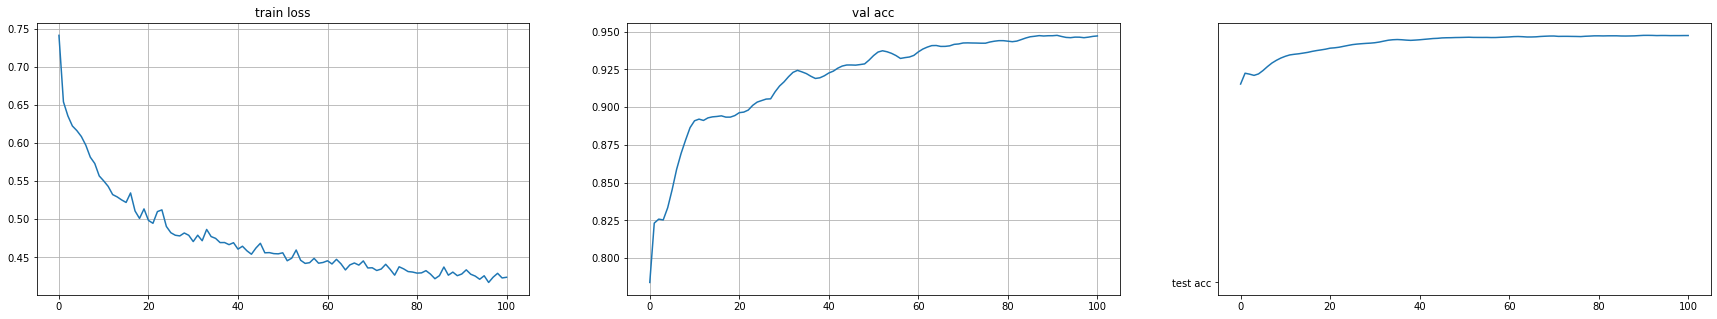

Epoch: 100, Train Loss: 0.448613, Val Auc: 0.923283, Test Auc: 0.921717


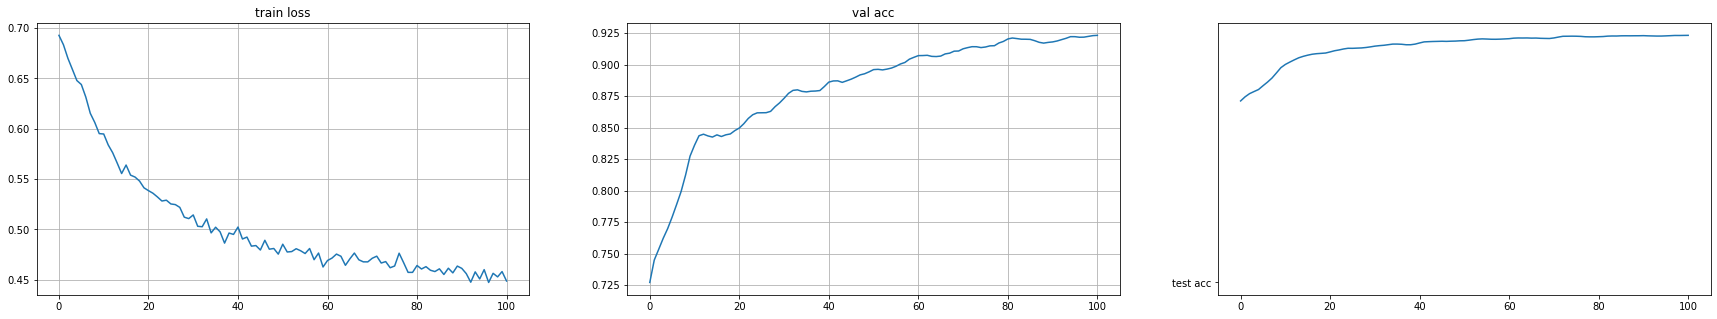

Epoch: 100, Train Loss: 0.564492, Val Auc: 0.803540, Test Auc: 0.833613


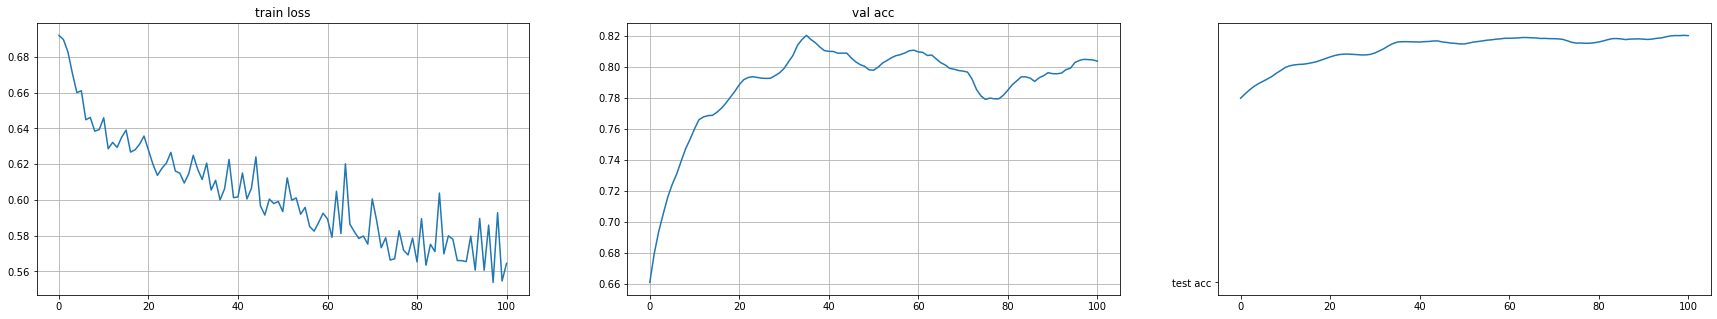

Epoch: 100, Train Loss: 0.434380, Val Auc: 0.946370, Test Auc: 0.938962


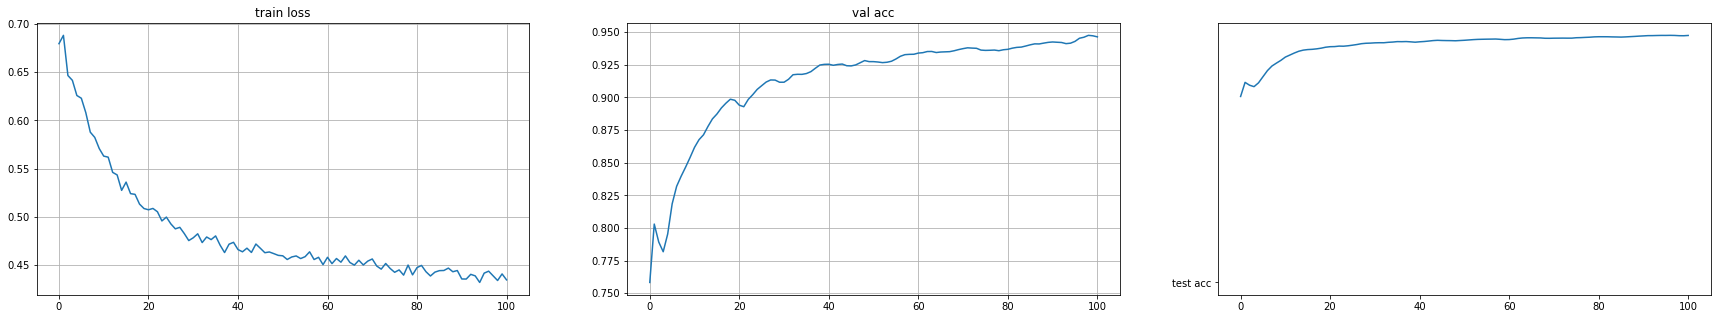

Epoch: 100, Train Loss: 0.549402, Val Auc: 0.858376, Test Auc: 0.874399


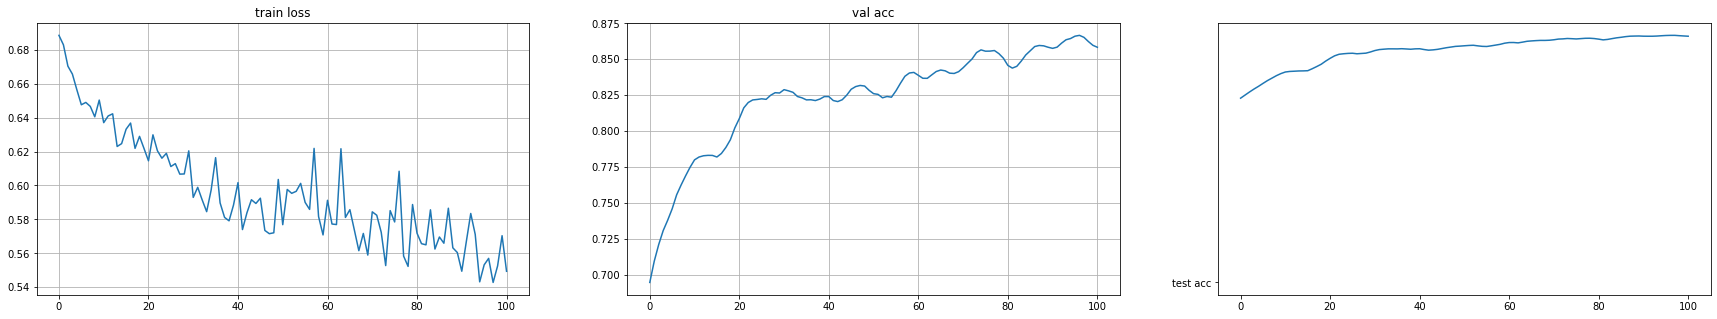

Epoch: 100, Train Loss: 0.464302, Val Auc: 0.907745, Test Auc: 0.923769


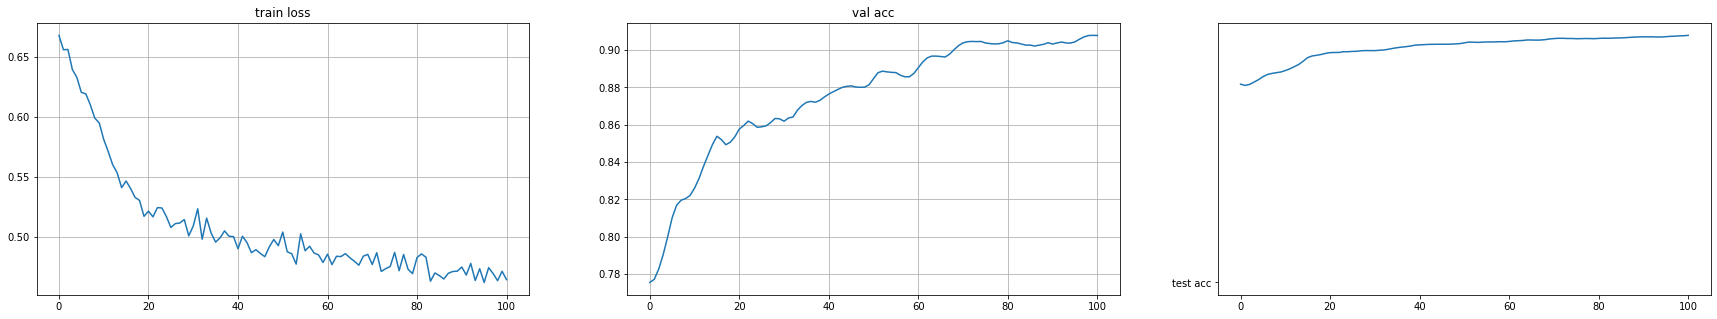

In [48]:
folds = k_fold_edge_split(data, only_upper_triangular_portion=True, val_ratio=0.2, test_ratio=0.2)
folds.append(data)

device = device_finder()

folds = k_fold_edge_split(data, only_upper_triangular_portion=False)

in_channels = folds[0].num_features
hid_channels = 128
out_channels = 64

t_list = []
v_list = []
te_list = []
prob_adj_list = []

for index in range(0, 6):
    train_loss, val_auc, test_auc, model, prob_adj = train_model_on_folds_and_decode_all(folds=folds, data=data,
                                num_epochs=101, index=index, in_channels=in_channels, hid_channels=hid_channels, 
                                out_channels=out_channels, device=device, model_class=Net, lr=0.0005, verbose=0)    
    t_list.append(train_loss[99])
    v_list.append(val_auc[99])
    te_list.append(test_auc[99])
    prob_adj_list.append(prob_adj)
    
    all_t_list.append(t_list)
    all_v_list.append(v_list)
    all_te_list.append(te_list)

Data(x=[389, 3256], edge_index=[2, 1132])

In [62]:
all_top_pairs = predict_all_top_edges(prob_adj_list, data)
all_new_pairs = predict_top_new_edges(all_top_pairs)

KeyError: 0

In [53]:
model_names = ['GCN', 'SAGE', 'GAT', 'SAGE-GCN', 'GAT-SAGE', 'GCN-GAT']
feature_names = ['dt', 'w2v', 'n2v', 'fin', 'ind', 'se', 'all']
colors = ['black', 'gray', 'black', 'gray', 'black', 'gray', 'black']
method_names = []
all_test = []
print(' '* 13, end='')
for i, name in enumerate(feature_names):
    if i % 6 != 5:
        print(f'{name:<7}', end=' ')
    else:
        print(f'{name:<4}', end='')
print()
for i, model in enumerate(feature_names):
    print(f'{model_names[i]:<10}', end='  ')
    for j, feature in enumerate(model_names):
        if j % 6 != 5:
            print(format(all_te_list[i][j], '.3f'), end='   ')
        else:
            print(format(all_te_list[i][j], '.3f'), end='')
        method_names.append(f'{feature} on {model}')
        all_test.append(all_te_list[i][j])
    if i % 6 == 5:
        print('')
    print()

plotter(all_test, method_names, colors)

             dt      w2v     n2v     fin     ind     se  all     
GCN         0.938   0.866   0.793   0.898   0.821   0.886
SAGE        0.950   0.916   0.876   0.937   0.898   0.945
GAT         0.976   0.938   0.892   0.963   0.911   0.970
SAGE-GCN    0.900   0.845   0.761   0.866   0.800   0.842
GAT-SAGE    0.948   0.915   0.693   0.929   0.833   0.929
GCN-GAT     0.956   0.922   0.808   0.943   0.868   0.919



IndexError: list index out of range

In [ ]:
#              dt      w2v     n2v     fin     ind     se  
# GCN         0.924   0.854   0.773   0.895   0.802   0.860
# SAGE        0.946   0.914   0.855   0.936   0.904   0.935
# GAT         0.973   0.936   0.888   0.963   0.908   0.965
# SAGE-GCN    0.894   0.855   0.780   0.871   0.788   0.840
# GAT-SAGE    0.944   0.897   0.715   0.927   0.829   0.917
# GCN-GAT     0.942   0.914   0.798   0.932   0.857   0.909


# scores = [0.924, 0.854, 0.773, 0.895, 0.802, 0.860,
#         0.946, 0.914, 0.855, 0.936, 0.904, 0.935,
#         0.973, 0.936, 0.888, 0.963, 0.908, 0.965,
#         0.894, 0.855, 0.780, 0.871, 0.788, 0.840,
#         0.944, 0.897, 0.715, 0.927, 0.829, 0.917,
#         0.942, 0.914, 0.798, 0.932, 0.857, 0.909,
#         0.937, 0.918, 0.846, 0.936, 0.879, 0.909]

In [395]:
scores = [0.924, 0.854, 0.773, 0.895, 0.802, 0.860,
0.946, 0.914, 0.855, 0.936, 0.904, 0.935,
0.973, 0.936, 0.888, 0.963, 0.908, 0.965,
0.894, 0.855, 0.780, 0.871, 0.788, 0.840,
0.944, 0.897, 0.715, 0.927, 0.829, 0.917,
0.942, 0.914, 0.798, 0.932, 0.857, 0.909,
0.937, 0.918, 0.846, 0.936, 0.879, 0.909]

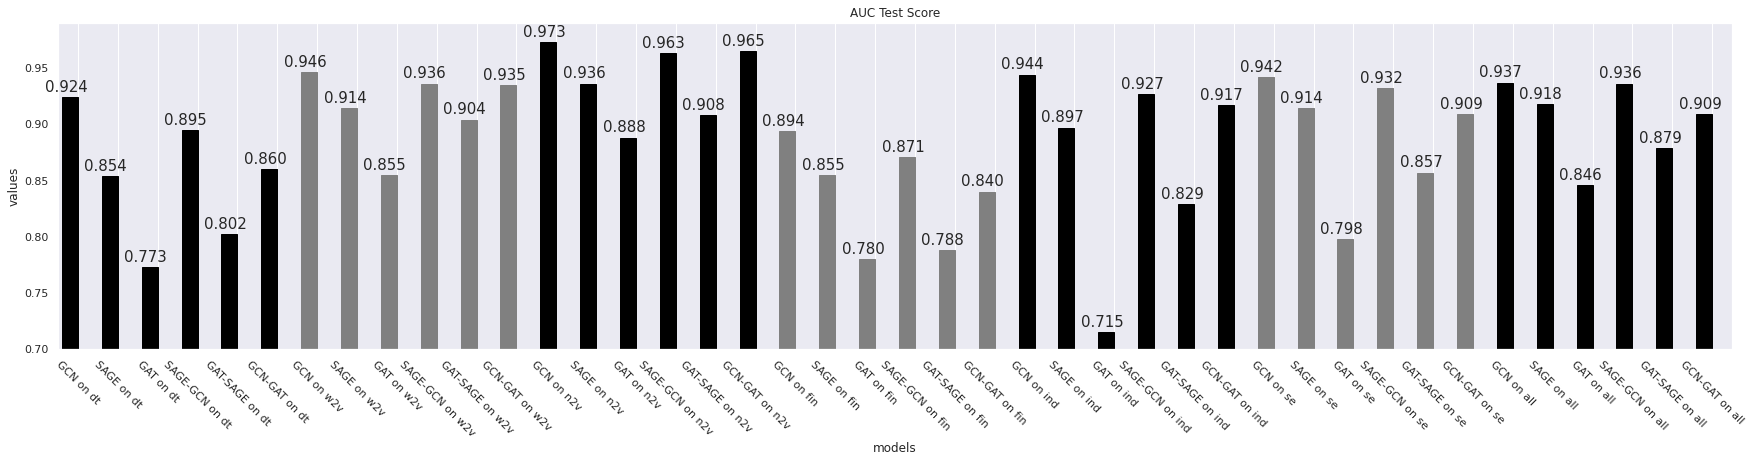

In [399]:
model_names = ['GCN', 'SAGE', 'GAT', 'SAGE-GCN', 'GAT-SAGE', 'GCN-GAT']
feature_names = ['dt', 'w2v', 'n2v', 'fin', 'ind', 'se', 'all']
colors = ['black', 'gray', 'black', 'gray', 'black', 'gray', 'black']
method_names = []
all_test = []
# print(' '* 13, end='')
# for i, name in enumerate(feature_names):
#     if i % 6 != 5:
#         print(f'{name:<7}', end=' ')
#     else:
#         print(f'{name:<4}', end='')
# print()
for i, model in enumerate(feature_names):
    # print(f'{model_names[i]:<10}', end='  ')
    for j, feature in enumerate(model_names):
    #     if j % 6 != 5:
    #         print(format(all_te_list[i][j], '.3f'), end='   ')
    #     else:
    #         print(format(all_te_list[i][j], '.3f'), end='')
        method_names.append(f'{feature} on {model}')
    #     all_test.append(all_te_list[i][j])
    # if i % 6 == 5:
    #     print('')
    # print()

plotter(scores, method_names, colors)

In [422]:
scores = np.array(scores)
scores = np.reshape(scores, (7, 6))
print(scores)

[[0.924 0.854 0.773 0.895 0.802 0.86 ]
 [0.946 0.914 0.855 0.936 0.904 0.935]
 [0.973 0.936 0.888 0.963 0.908 0.965]
 [0.894 0.855 0.78  0.871 0.788 0.84 ]
 [0.944 0.897 0.715 0.927 0.829 0.917]
 [0.942 0.914 0.798 0.932 0.857 0.909]
 [0.937 0.918 0.846 0.936 0.879 0.909]]


(6,)
(7,)

['GCN', 'SAGE', 'GAT', 'SAGE-GCN', 'GAT-SAGE', 'GCN-GAT']
['dt', 'w2v', 'n2v', 'fin', 'ind', 'se', 'all']


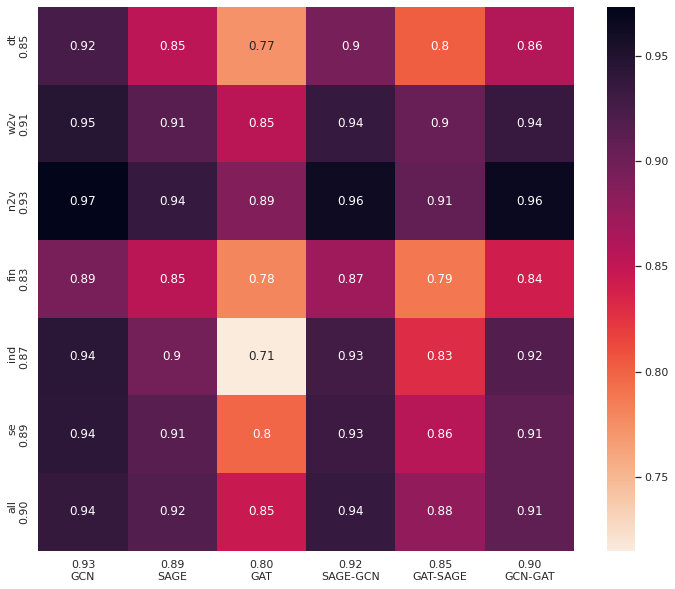

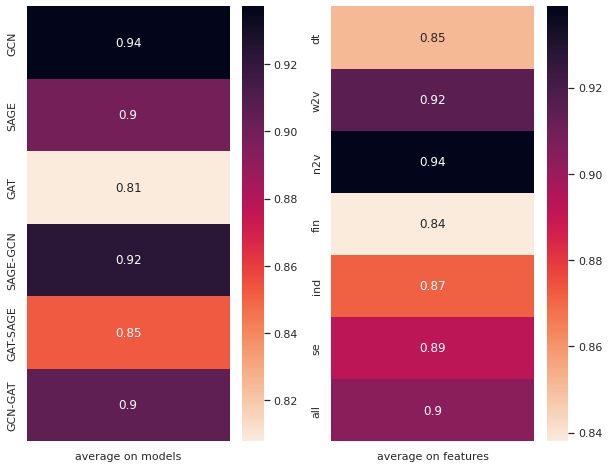

In [464]:
model_names = ['GCN', 'SAGE', 'GAT', 'SAGE-GCN', 'GAT-SAGE', 'GCN-GAT']
m_names = model_names[:]
feature_names = ['dt', 'w2v', 'n2v', 'fin', 'ind', 'se', 'all']
f_names = feature_names[:]

ave_col = np.average(scores, axis=0)
ave_row = np.average(scores, axis=1)

print(ave_col.shape)
print(ave_row.shape)
print()
for i in range(len(model_names)):
    m_names[i] = f'{str(ave_col[i])[:4]}\n{model_names[i]}'

for i in range(len(feature_names)):
    f_names[i] = f'{feature_names[i]}\n{str(ave_row[i])[:4]}'

print(model_names)
print(feature_names)

import seaborn as sns; sns.set_theme()

heat_scores = [[0.924, 0.854, 0.773, 0.895, 0.802, 0.860],
[0.946, 0.914, 0.855, 0.936, 0.904, 0.935],
[0.973, 0.936, 0.888, 0.963, 0.908, 0.965],
[0.894, 0.855, 0.780, 0.871, 0.788, 0.840],
[0.944, 0.897, 0.715, 0.927, 0.829, 0.917],
[0.942, 0.914, 0.798, 0.932, 0.857, 0.909],
[0.937, 0.918, 0.846, 0.936, 0.879, 0.909]]

cmap = sns.cm.rocket_r

plt.figure(figsize=(12, 10))
ax = sns.heatmap(heat_scores, annot=True, cmap=cmap)
ax.set_xticklabels(m_names)
ax.set_yticklabels(f_names)
plt.show()

############################################

cmap = sns.cm.rocket_r
plt.figure(figsize=(10, 8))

plt.subplot(121)
ave_col = np.reshape(ave_col, (ave_col.shape[0], 1))
ax = sns.heatmap(ave_col, annot=True, cmap=cmap)
ax.set_xticklabels(['average on models'])
ax.set_yticklabels(model_names)
############################
plt.subplot(122)
ave_row = np.reshape(ave_row, (ave_row.shape[0], 1))
ax = sns.heatmap(ave_row, annot=True, cmap=cmap)
ax.set_xticklabels(['average on features'])
ax.set_yticklabels(feature_names)
plt.show()


In [466]:
heat_scores = [[0.924, 0.854, 0.773, 0.895, 0.802, 0.860],
[0.946, 0.914, 0.855, 0.936, 0.904, 0.935],
[0.973, 0.936, 0.888, 0.963, 0.908, 0.965],
[0.894, 0.855, 0.780, 0.871, 0.788, 0.840],
[0.944, 0.897, 0.715, 0.927, 0.829, 0.917],
[0.942, 0.914, 0.798, 0.932, 0.857, 0.909],
[0.937, 0.918, 0.846, 0.936, 0.879, 0.909]]

sum = 0
for i in range(len(heat_scores)):
    for j in range(len(heat_scores[0])):
        sum += heat_scores[i][j]
print(sum / 42)

0.8872619047619046


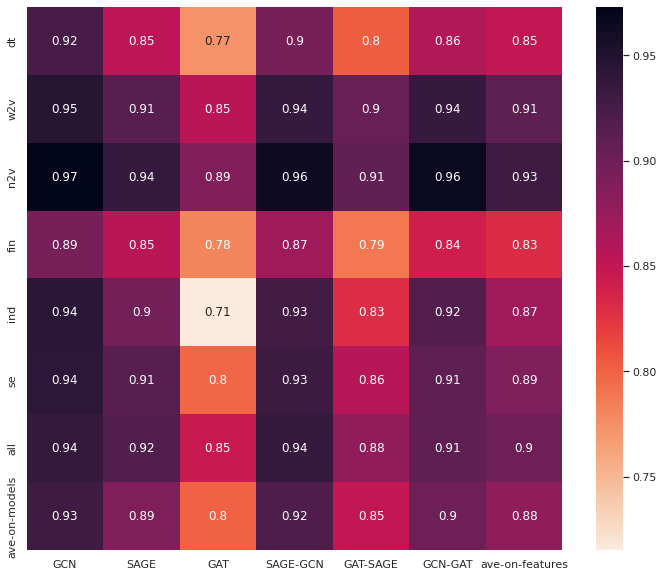

In [468]:
model_names = ['GCN', 'SAGE', 'GAT', 'SAGE-GCN', 'GAT-SAGE', 'GCN-GAT', 'ave-on-features']
m_names = model_names[:]
feature_names = ['dt', 'w2v', 'n2v', 'fin', 'ind', 'se', 'all', 'ave-on-models']
f_names = feature_names[:]

heat_scores = [[0.924, 0.854, 0.773, 0.895, 0.802, 0.860, 0.85],
[0.946, 0.914, 0.855, 0.936, 0.904, 0.935, 0.91],
[0.973, 0.936, 0.888, 0.963, 0.908, 0.965, 0.93],
[0.894, 0.855, 0.780, 0.871, 0.788, 0.840, 0.83],
[0.944, 0.897, 0.715, 0.927, 0.829, 0.917, 0.87],
[0.942, 0.914, 0.798, 0.932, 0.857, 0.909, 0.89],
[0.937, 0.918, 0.846, 0.936, 0.879, 0.909, 0.90],
[0.93,  0.89,  0.80,  0.92,  0.85,  0.90,  0.88]]

cmap = sns.cm.rocket_r

plt.figure(figsize=(12, 10))
ax = sns.heatmap(heat_scores, annot=True, cmap=cmap)
ax.set_xticklabels(m_names)
ax.set_yticklabels(f_names)
plt.show()